# Trend Detection in Enterprise Search
In 1999, the operators of the Lycos commercial Web Search engine began publishing a weekly list of the 50 most popular queries submitted.   The query term ‘Britney Spears’ was number two on the list.   The popularity of that term endured and ‘Britney Spears’ never fell off the list over the next eight years.   This meant that the list was quite static and other topics volumetrically drowned out.  This has sometimes been referred to as ‘The Britney Spears Problem’ ~\cite(Hayes2008).
A more dynamic list tells us what topic or query is up and coming or generating a ‘buzz’ as measured by a sudden abnormal burst of interest.   This concept is known as trending and is based on the relative spike in volume of clustered topic searches in relation to absolute volume of searches. Unlike the popularity list, the trend list would exclude the constantly popular ‘Britney Spears’.     


To measure an abnormal spike, we must first determine what would be a normal baseline score.  This type of calculation lends itself to z-scores, which considers the burst of popularity against the backdrop of the historical average (including its standard deviation).   

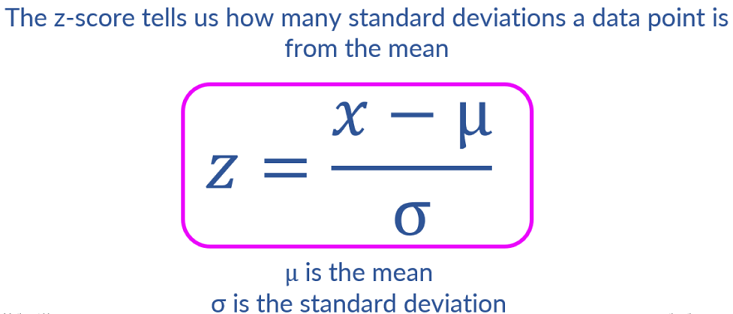

**From the above formula, we see that positive and high z-score indicates an abnormal rising trend.**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/tcd-queries/tcd-completions.txt-v25
/kaggle/input/tcd-queries/aol-query-count.txt
/kaggle/input/tcd-queries/tcd-history.txt-v25
/kaggle/input/tcd-queries/aol-completions-qac.txt
/kaggle/input/tcd-queries/tcd-today-searches.txt-v26


In [3]:
# import the two-column query history 
query_history_file="/kaggle/input/tcd-queries/tcd-history.txt-v25"
column_names = ['queries', 'total_volume']
df_historical = pd.read_csv(
    query_history_file,
    sep ="\t",
    names=column_names,
    header=None
)

In [4]:
# import the two-column query history 
query_today_file="/kaggle/input/tcd-queries/tcd-today-searches.txt-v26"
column_names = ['queries', 'today_volume']
df_today = pd.read_csv(
    query_today_file,
    sep ="\t",
    names=column_names,
    header=None
)

In [5]:
print(len(df_historical.index))
print(len(df_today.index))

62044
4974


In [6]:
# divide volume by total number of days
days=20
df_historical['mean_daily_volume'] = df_historical['total_volume'].div(days).round(2)

#verify with awk



In [7]:
df_historical.head(3)

,queries,total_volume,mean_daily_volume
0,scholarship,2148,107.40
1,fees,1941,97.05
2,library,1849,92.45


In [8]:
df_today.head(3)

,queries,today_volume
0,scholarship,108
1,fees,105
2,library,101


In [9]:
std_deviation=df_historical['mean_daily_volume'].std()
print ("{:.2f}".format(std_deviation))

1.42


In [10]:
# make new dataframe consisting only of entries common to df_historical['queries'] and df_today['queries'], include all columns
# Inner join: only the rows with matching keys in both dataframes are included in the resulting merged dataframe.
merged_df = pd.merge(df_historical, df_today, on='queries')
merged_df.head(5)

,queries,total_volume,mean_daily_volume,today_volume
0,scholarship,2148,107.40,108
1,fees,1941,97.05,105
2,library,1849,92.45,101
3,phd,1751,87.55,72
4,medicine,1573,78.65,79


In [11]:
merged_df.dtypes

queries               object
total_volume           int64
mean_daily_volume    float64
today_volume           int64
dtype: object

In [12]:
# this is the cell where we calculate (manually) the zscore for each query.    z = (x - mu)/sigma, where x - mu is delta
merged_df['delta']  = merged_df['today_volume'] - merged_df['mean_daily_volume']
merged_df['zscore'] = merged_df['delta'] / std_deviation

In [13]:
merged_df = merged_df.sort_values(by='zscore', ascending=False)
merged_df.head(3)

,queries,total_volume,mean_daily_volume,today_volume,delta,zscore
192,graduate studies,111,5.55,38,32.45,22.813449
6,erasmus,1322,66.10,91,24.90,17.505543
34,dentistry,431,21.55,43,21.45,15.080076


In [14]:
# verify using sample query that zscore is correct: -
zscore_fees=((105-(1909/30))/0.94); print (zscore_fees)

44.00709219858156


In [15]:
trends=merged_df[merged_df.zscore > 1.96]
trends.head(3)


,queries,total_volume,mean_daily_volume,today_volume,delta,zscore
192,graduate studies,111,5.55,38,32.45,22.813449
6,erasmus,1322,66.10,91,24.90,17.505543
34,dentistry,431,21.55,43,21.45,15.080076


In [16]:
#how many trending queries do we have?
len(trends.index)

284

In [17]:
#drop all columns except queries and zscore
trends = trends[['queries','zscore']]
trends.head(3)

,queries,zscore
192,graduate studies,22.813449
6,erasmus,17.505543
34,dentistry,15.080076


In [18]:
#save txt file, solr requires 'tab' between query and weighting(zscore)
trends.to_csv('tcd-trending.txt', index=False, header=False, sep ='\t')


In [19]:
#!head -3 tcd-trending.txt
!wc tcd-trending.txt
!cat --show-tabs tcd-trending.txt  | head -4  # view top n trending queryies and verify sepatator is a tab (with no spaces)

 284  760 9009 tcd-trending.txt
graduate studies^I22.813448967710638
erasmus^I17.505543275685515
dentistry^I15.080076436283301
law^I11.670362183790342


**The generated tcd-trending.txt file can now be placed in the /opt/solr/server/solr/CORPUS/data directory**